Importing necessary libraries

In [1]:
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1. A map of movement (Folium)

In [2]:
from math import radians, cos, sin, asin,sqrt
def haversine(lon1,lat1,lon2,lat2):
    lon1, lat1, lon2, lat2 = map(radians,[lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r 
data = pd.read_csv('GPS_data.csv')
data.head()

,Unnamed: 0,seconds_elapsed,longitude,latitude
0,0,3.703666,25.516165,65.071375
1,1,5.339879,25.516227,65.071393
2,2,5.680000,25.516240,65.071398
3,3,6.311351,25.516264,65.071394
4,4,7.323929,25.516267,65.071396


In [3]:
lat = data['latitude']
lon = data['longitude']

data['dist'] = np.zeros(lat.shape[0])
data['time_diff'] = np.zeros(lat.shape[0])

for i in range(lat.shape[0]-1):
    data['dist'][i] = haversine(lon[i], lat[i], lon[i+1], lat[i+1]) * 1000
    data['time_diff'][i] = data['seconds_elapsed'][i+1] - data['seconds_elapsed'][i]

data['dist'][0] = 0
data['total_dist'] = data['dist'].cumsum()
data['velocity'] = data['dist'] / data['time_diff']
data['acceleration'] = (data['velocity'].diff()) / (data['seconds_elapsed'].diff())

location_frame = data[['latitude', 'longitude']]
location_list = location_frame.values.tolist()

ave_lat = np.mean(location_list, axis=0)[0]
ave_lon = np.mean(location_list, axis=0)[1]

my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=16)

folium.PolyLine(location_list, color="red", weight=2.2, opacity=1).add_to(my_map)

my_map

/var/folders/xb/9h2nrgp94j92d1czk9c_4gsh0000gn/T/ipykernel_26577/2022130180.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['dist'][i] = haversine(lon[i], lat[i], lon[i+1], lat[i+1]) * 1000
/var/folders/xb/9h2nrgp94j92d1czk9c_4gsh00

2. Distance graph (increasing from zero)


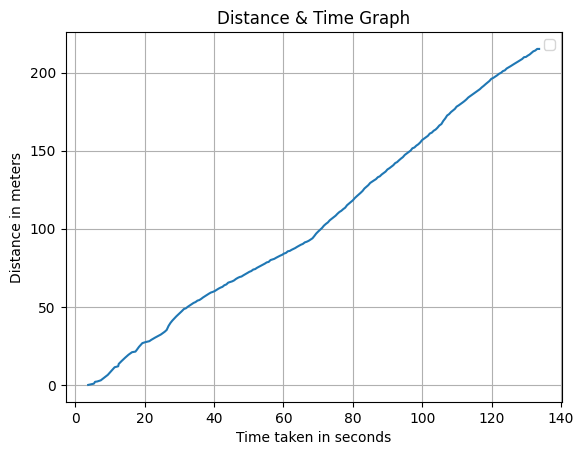

In [4]:
plt.subplot(1,1,1)
plt.title('Distance & Time Graph')
plt.legend(['Distance from GPS'])
plt.plot(data['seconds_elapsed'],data['total_dist'])
plt.xlabel('Time taken in seconds')
plt.ylabel('Distance in meters')
plt.grid()
plt.show()

3. Velocity graph (calculated from coordinates)

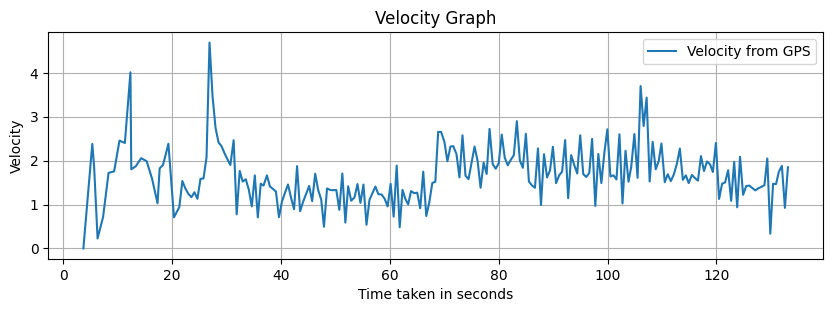

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Velocity Graph')
plt.plot(data['seconds_elapsed'], data['velocity'])
plt.legend(['Velocity from GPS'])
plt.xlabel('Time taken in seconds')
plt.ylabel('Velocity')
plt.grid()
plt.show()



4.Acceleration graph (observed [three components] and calculated from speed [one component]).

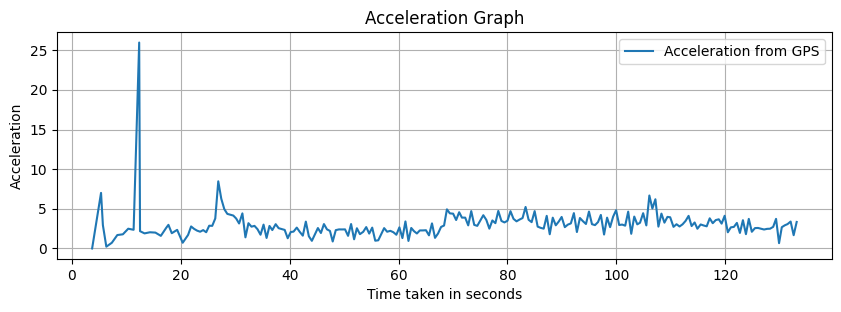

In [6]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
data['calculated_acceleration'] = data['velocity'] / data['time_diff']
plt.plot(data['seconds_elapsed'], data['calculated_acceleration'])
plt.legend(['Acceleration from GPS'])
plt.title('Acceleration Graph')
plt.xlabel('Time taken in seconds')
plt.ylabel('Acceleration')
plt.grid()
plt.show()


5.Average speed and distance travelled as a number

In [7]:
print("The average speed is ", data['velocity'].mean(), "m/s")
print("The total distance travelled is ", data['total_dist'].iloc[-1], "m")

The average speed is  1.6782391458590495 m/s
The total distance travelled is  215.14092455483328 m


6. The number of steps 


In [8]:
data_acc = pd.read_csv('Acceleration_data.csv')
data_acc.head()

,Unnamed: 0,seconds_elapsed,z,y,x
0,0,0.143440,-2.846008,-0.581977,-0.468246
1,1,0.159217,-2.651466,-0.560432,-0.418557
2,2,0.175117,-2.132024,-0.366186,-0.535990
3,3,0.190986,-1.023350,-0.041039,-0.522485
4,4,0.206763,-0.449766,0.229015,-0.356920


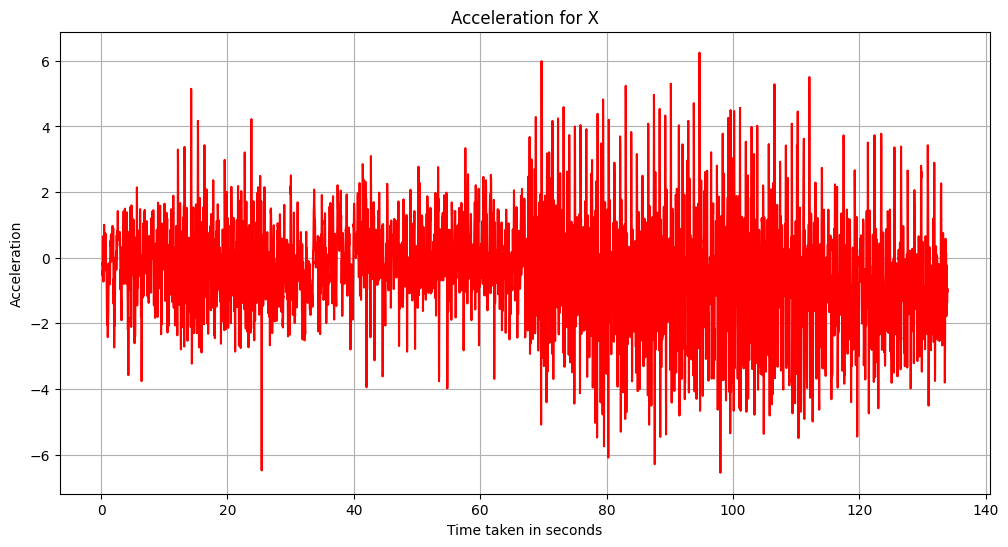

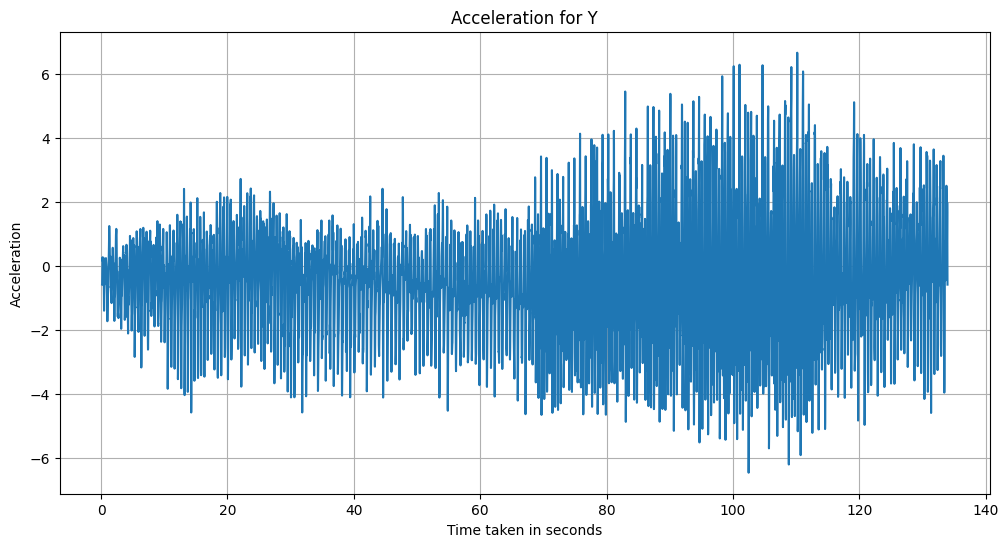

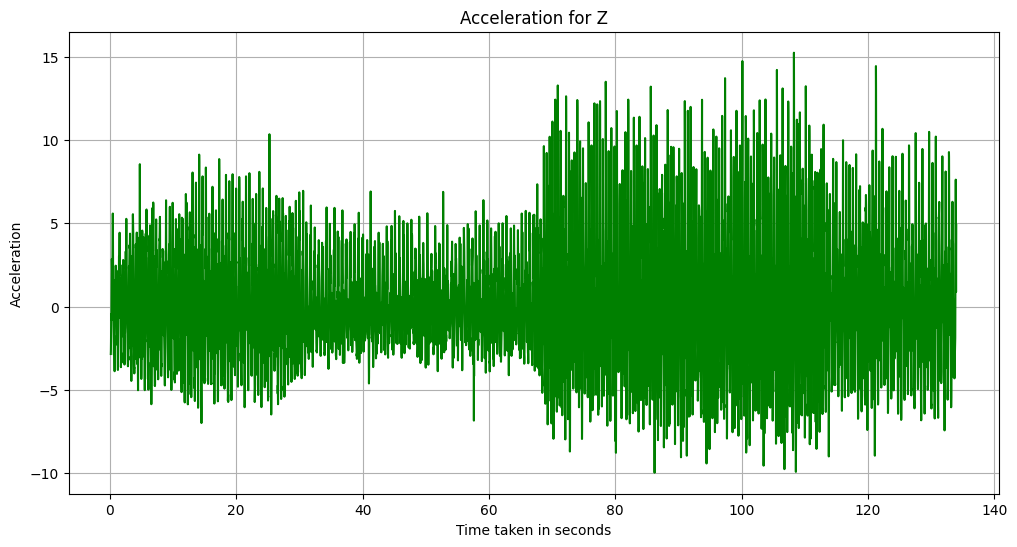

In [9]:
# Plotting observed acceleration Y from data provided

accel = pd.read_csv('Acceleration_data.csv')
plt.figure(figsize=(12, 6))
plt.plot(accel['seconds_elapsed'], accel['x'],color='red')
plt.xlabel('Time taken in seconds')
plt.ylabel('Acceleration')
plt.title('Acceleration for X')
plt.grid()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(accel['seconds_elapsed'], accel['y'])
plt.xlabel('Time taken in seconds')
plt.ylabel('Acceleration')
plt.title('Acceleration for Y')
plt.grid()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(accel['seconds_elapsed'], accel['z'],color='green')
plt.xlabel('Time taken in seconds')
plt.ylabel('Acceleration')
plt.title('Acceleration for Z')
plt.grid()
plt.show()

The number of steps is: 255.5


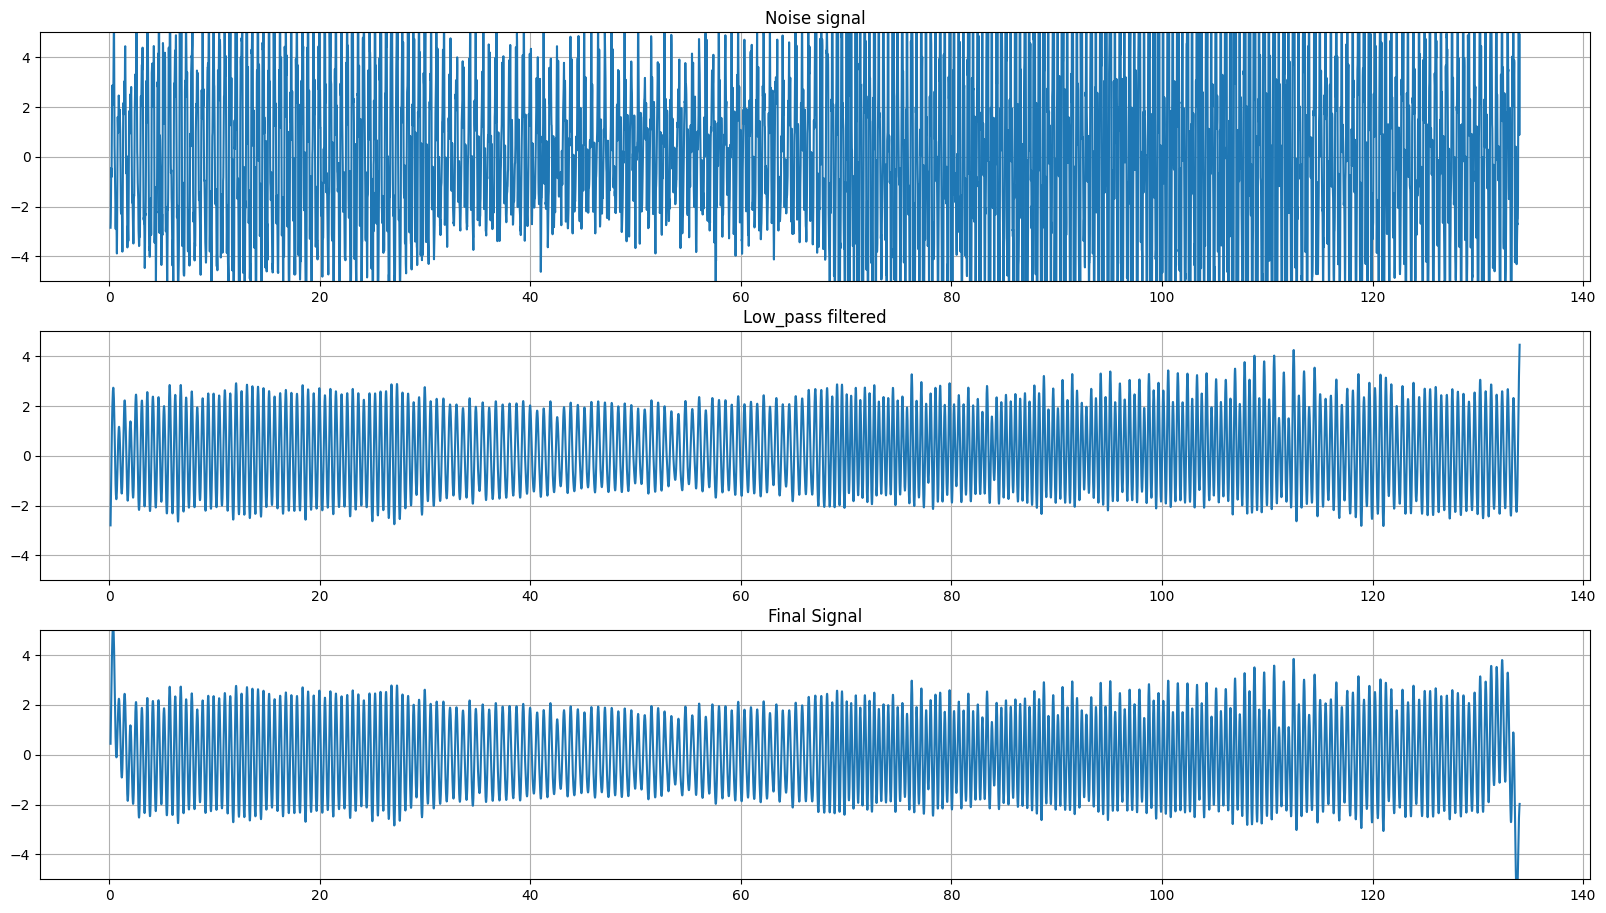

In [11]:
# Noise Filtering 
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff,fs, nyq, order):
    normal_cutoff = cutoff/nyq

    b, a = butter(order, normal_cutoff,btype='low', analog=False)
    z = filtfilt(b, a, data)
    return z

def butter_highpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff/nyq

    b, a = butter(order, normal_cutoff,btype='high', analog=False)
    z = filtfilt(b, a, data)
    return z

# Filtering signal

noise_signal = data_acc['z']
time = data_acc['seconds_elapsed']
order = 2
dt = (time[len(time) - 1] - time[0])/len(time)

fs = 1/dt
nyq = 0.5 * fs
cutoff_H = 1/5
cutoff_L = 1/0.5

lowpass_filtered = butter_lowpass_filter(noise_signal, cutoff_L, fs, nyq, order)
final_signal = butter_highpass_filter(lowpass_filtered, cutoff_H, fs, nyq, order)


plt.figure(figsize=(20,11))
plt.subplot(3,1,1)
plt.plot(time,noise_signal)
plt.title('Noise signal')
plt.grid()
plt.ylim(-5,5)

plt.subplot(3,1,2)
plt.plot(time,lowpass_filtered)
plt.title('Low_pass filtered')
plt.grid()
plt.ylim(-5,5)

plt.subplot(3,1,3)
plt.plot(time,final_signal)
plt.title('Final Signal')
plt.grid()
plt.ylim(-5,5)

stepdata = final_signal
steps = 0
for i in range(stepdata.shape[0]-1):
    if stepdata[i]/stepdata[i+1] < 0:
        steps = steps + 0.5
print('The number of steps is:', steps)

Answer the following questions:

1. Does the acceleration calculated from the speed match the observed acceleration? What differences do you notice? What could be their cause?

No, the observed acceleration and the accelarion calculated doesn't quite match with eachother. This might be because of the movements or irregularies while using the phone during the data collection or measurements.

2. Is the number of steps logical?

Yes, I think the number of steps are logical although they might not be accurate. The difference in the real and the actual step can vary but I believe it must be close to the actual number of steps taken during the measurement of the data.